## Final Project Submission

Please fill out:
* Student name: Oruko David Owen
* Student pace: full time
* Scheduled project review date/time: 1 week 
* Instructor name: Winne Anyoso 
* Blog post URL:


## 1.0 Business Understanding 

## 1.1 Problem Statement 

The real estate industry is a critical sector in the economy, and accurately predicting house prices can provide valuable insights for various stakeholders. Whether it's buyers looking for a fair purchase price, sellers determining an appropriate listing price, or investors assessing potential profitability, understanding the factors that influence house prices is essential. In this analysis, we aim to develop regression models that can predict house prices based on a set of relevant features.


## 1.2 Main Objective 


The main objective of this analysis is to develop regression models that can accurately predict house prices based on a set of independent variables. By achieving this objective, we aim to provide a valuable tool for individuals and organizations involved in buying, selling, or investing in real estate. Accurate predictions can help buyers make informed decisions, assist sellers in setting appropriate listing prices, and enable investors to assess potential profitability.


## 1.3 Specific Objectives

Develop and compare multiple regression models, including Linear Regression, Random Forest Regression, and XGBoost Regression, to predict house prices.
Evaluate the performance of each regression model using appropriate evaluation metrics such as R-squared, adjusted R-squared, mean absolute error (MAE), mean squared error (MSE), and root mean squared error (RMSE).
Identify the most accurate and reliable regression model for predicting house prices based on the given dataset.
Provide recommendations on the use of the regression models for predicting house prices and insights into the factors that influence house prices in the market.

## 1.4 Experimental Design



Data Collection: Obtain a dataset containing relevant information about house sales, including features such as size, location, condition, and price.
Exploratory Data Analysis: Perform initial data exploration to understand the distribution of variables, identify missing values or outliers, and gain insights into the relationships between variables.
Data Preprocessing: Handle missing values, outliers, and categorical variables as necessary. Perform feature engineering, including transformations, creation of new variables, or scaling, to improve the predictive power of the models.
Model Development: Develop regression models using techniques such as Linear Regression, Random Forest Regression, and XGBoost Regression. Split the dataset into training and testing sets for model training and evaluation.
Model Evaluation: Assess the performance of each model using evaluation metrics such as R-squared, adjusted R-squared, MAE, MSE, and RMSE. Compare the models to identify the most accurate and reliable one.
Model Selection and Recommendations: Select the best-performing model based on the evaluation metrics and provide recommendations on its use for predicting house prices. Offer insights into the significant predictors and their impact on house prices.
Model Deployment: Deploy the chosen regression model in a suitable environment, ensuring it is easily accessible and user-friendly for stakeholders. Monitor and update the model as new data becomes available to maintain accuracy and relevance.

## 2.0 Data Understanding 

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors

## 2.1 Importing necessary Libraries

In [38]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [265]:
# Loading the data on kc house data 
data = pd.read_csv("kc_house_data.csv")
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


The len() function shows the available data points of the data which is 21597.

In [232]:
len(data)

21597

In [233]:
# Using the .head() method displays the top 5 rows 
data.head(34)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,11 Excellent,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,7 Average,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,NO,NaN,...,7 Average,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,NO,NONE,...,7 Average,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,NO,NONE,...,7 Average,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [234]:
# The .tail method is used to display the last 5 rows.
data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287
21596,1523300157,10/15/2014,325000.0,2,0.75,1020,1076,2.0,NO,NONE,...,7 Average,1020,0.0,2008,0.0,98144,47.5941,-122.299,1020,1357


In [235]:
# .shape is used to show the number of rows and columns specifically
data.shape

(21597, 21)

This data set contains 21597 rows and 21 columns.

In [236]:
data.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

There are 3 fields with missing values.
* waterfront       2376
* view               63
* yr_renovated     3842

## 3.0 Data Preparation 

### 3.1 Data Information

In [237]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The .info() method helps to check for null values in the dataset.

### 3.2 Descriptive Statistics 

In [238]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


The .describe() method gives us summary statistics for numerical columns in our DataFrame.

### Then Transpose 

The transpose() method switches it columns to become rows and rows to columns for a better interpretation of the dataset.

In [239]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,21597.0,4.580474e+09,2.876736e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21597.0,5.402966e+05,3.673681e+05,7.800000e+04,3.220000e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21597.0,3.373200e+00,9.262989e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21597.0,2.115826e+00,7.689843e-01,5.000000e-01,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21597.0,2.080322e+03,9.181061e+02,3.700000e+02,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21597.0,1.509941e+04,4.141264e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068500e+04,1.651359e+06
floors,21597.0,1.494096e+00,5.396828e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
sqft_above,21597.0,1.788597e+03,8.277598e+02,3.700000e+02,1.190000e+03,1.560000e+03,2.210000e+03,9.410000e+03
yr_built,21597.0,1.971000e+03,2.937523e+01,1.900000e+03,1.951000e+03,1.975000e+03,1.997000e+03,2.015000e+03
yr_renovated,17755.0,8.363678e+01,3.999464e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.015000e+03


###  3.3 Sort Data by Price 

What this simply does is to sort the house prices either by ascending order or descending order.

In [240]:
data.sort_values("price")

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15279,40000362,5/6/2014,78000.0,2,1.00,780,16344,1.0,NO,NONE,...,5 Fair,780,0.0,1942,NaN,98168,47.4739,-122.280,1700,10387
465,8658300340,5/23/2014,80000.0,1,0.75,430,5050,1.0,NaN,NONE,...,4 Low,430,0.0,1912,0.0,98014,47.6499,-121.909,1200,7500
16184,3028200080,3/24/2015,81000.0,2,1.00,730,9975,1.0,NaN,NONE,...,5 Fair,730,0.0,1943,0.0,98168,47.4808,-122.315,860,9000
8267,3883800011,11/5/2014,82000.0,3,1.00,860,10426,1.0,NO,NONE,...,6 Low Average,860,0.0,1954,0.0,98146,47.4987,-122.341,1140,11250
2139,1623049041,5/8/2014,82500.0,2,1.00,520,22334,1.0,NO,NONE,...,5 Fair,520,0.0,1951,0.0,98168,47.4799,-122.296,1572,10570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,8907500070,4/13/2015,5350000.0,5,5.00,8000,23985,2.0,NO,EXCELLENT,...,12 Luxury,6720,1280.0,2009,0.0,98004,47.6232,-122.220,4600,21750
4407,2470100110,8/4/2014,5570000.0,5,5.75,9200,35069,2.0,NO,NONE,...,13 Mansion,6200,3000.0,2001,NaN,98039,47.6289,-122.233,3560,24345
9245,9208900037,9/19/2014,6890000.0,6,7.75,9890,31374,2.0,NO,EXCELLENT,...,13 Mansion,8860,1030.0,2001,0.0,98039,47.6305,-122.240,4540,42730
3910,9808700762,6/11/2014,7060000.0,5,4.50,10040,37325,2.0,YES,AVERAGE,...,11 Excellent,7680,2360.0,1940,2001.0,98004,47.6500,-122.214,3930,25449


In [241]:
# To reverse the above use ascending = False 
data.sort_values("price", ascending = False).head(20)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7245,6762700020,10/13/2014,7700000.0,6,8.00,12050,27600,2.5,NO,GOOD,...,13 Mansion,8570,3480.0,1910,1987.0,98102,47.6298,-122.323,3940,8800
3910,9808700762,6/11/2014,7060000.0,5,4.50,10040,37325,2.0,YES,AVERAGE,...,11 Excellent,7680,2360.0,1940,2001.0,98004,47.6500,-122.214,3930,25449
9245,9208900037,9/19/2014,6890000.0,6,7.75,9890,31374,2.0,NO,EXCELLENT,...,13 Mansion,8860,1030.0,2001,0.0,98039,47.6305,-122.240,4540,42730
4407,2470100110,8/4/2014,5570000.0,5,5.75,9200,35069,2.0,NO,NONE,...,13 Mansion,6200,3000.0,2001,NaN,98039,47.6289,-122.233,3560,24345
1446,8907500070,4/13/2015,5350000.0,5,5.00,8000,23985,2.0,NO,EXCELLENT,...,12 Luxury,6720,1280.0,2009,0.0,98004,47.6232,-122.220,4600,21750
1313,7558700030,4/13/2015,5300000.0,6,6.00,7390,24829,2.0,YES,NaN,...,12 Luxury,5000,2390.0,1991,0.0,98040,47.5631,-122.210,4320,24619
1162,1247600105,10/20/2014,5110000.0,5,5.25,8010,45517,2.0,YES,EXCELLENT,...,12 Luxury,5990,2020.0,1999,0.0,98033,47.6767,-122.211,3430,26788
8085,1924059029,6/17/2014,4670000.0,5,6.75,9640,13068,1.0,YES,EXCELLENT,...,12 Luxury,4820,4820.0,1983,2009.0,98040,47.5570,-122.210,3270,10454
2624,7738500731,8/15/2014,4500000.0,5,5.50,6640,40014,2.0,YES,EXCELLENT,...,12 Luxury,6350,290.0,2004,0.0,98155,47.7493,-122.280,3030,23408
8629,3835500195,6/18/2014,4490000.0,4,3.00,6430,27517,2.0,NO,NONE,...,12 Luxury,6430,0.0,2001,0.0,98004,47.6208,-122.219,3720,14592


### 3.4 Inspect each column 
The best way to inspect the whole dataset is through using a for loop and run through our data and post out the unique values.

In [242]:
for val in data:
    print(data[val].value_counts())
    print()

id
795000620     3
8910500150    2
7409700215    2
1995200200    2
9211500620    2
             ..
3649100387    1
2767603649    1
1446403617    1
5602000275    1
1523300157    1
Name: count, Length: 21420, dtype: int64

date
6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
            ... 
11/2/2014      1
1/31/2015      1
5/24/2015      1
5/17/2014      1
7/27/2014      1
Name: count, Length: 372, dtype: int64

price
450000.0    172
350000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
278800.0      1
439888.0      1
354901.0      1
942000.0      1
402101.0      1
Name: count, Length: 3622, dtype: int64

bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64

bathrooms
2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.0

## 3.5 Distribution of the data 

### 3.5.1 House Price Distribution

C:\Users\PC\AppData\Local\Temp\ipykernel_9240\4264540708.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='price', ylabel='Density'>

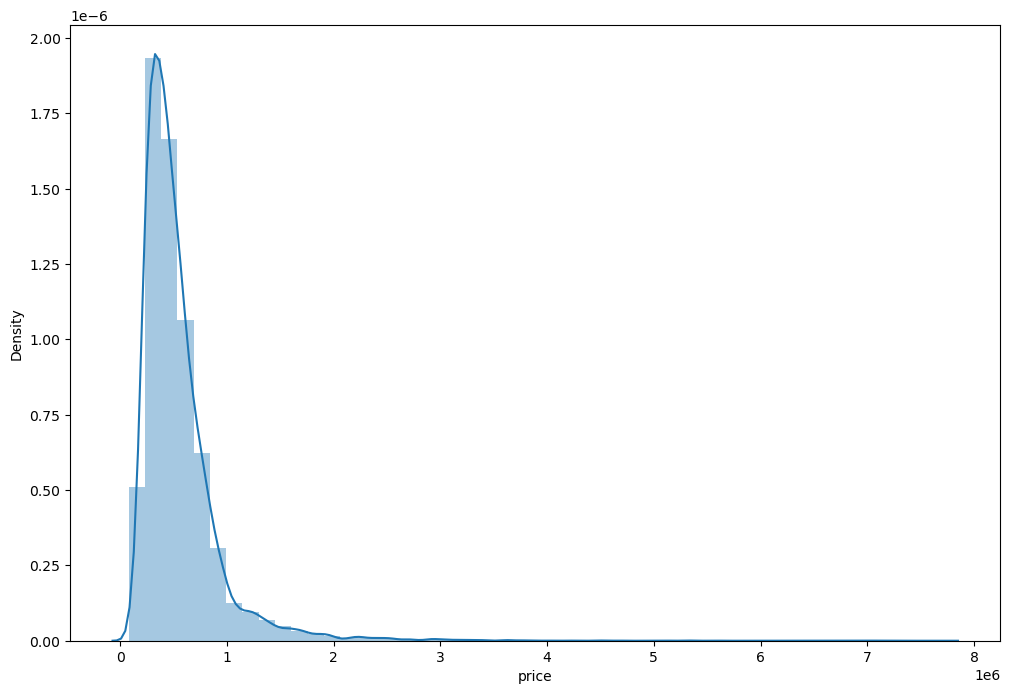

In [243]:
# House Price Distribution 
plt.figure(figsize = (12,8))
sns.distplot(data['price'])

What we are observing here is the bulk of property prices that are below the 1 million mark and there are extreme and then skewed to the right which may represent outliers.


There are a few properties above the 1 million mark but still the tail of the distplot.

### Living Space DIstribution

The living space describes - Square footage of living space in the home.



C:\Users\PC\AppData\Local\Temp\ipykernel_9240\3792371968.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='sqft_living', ylabel='Density'>

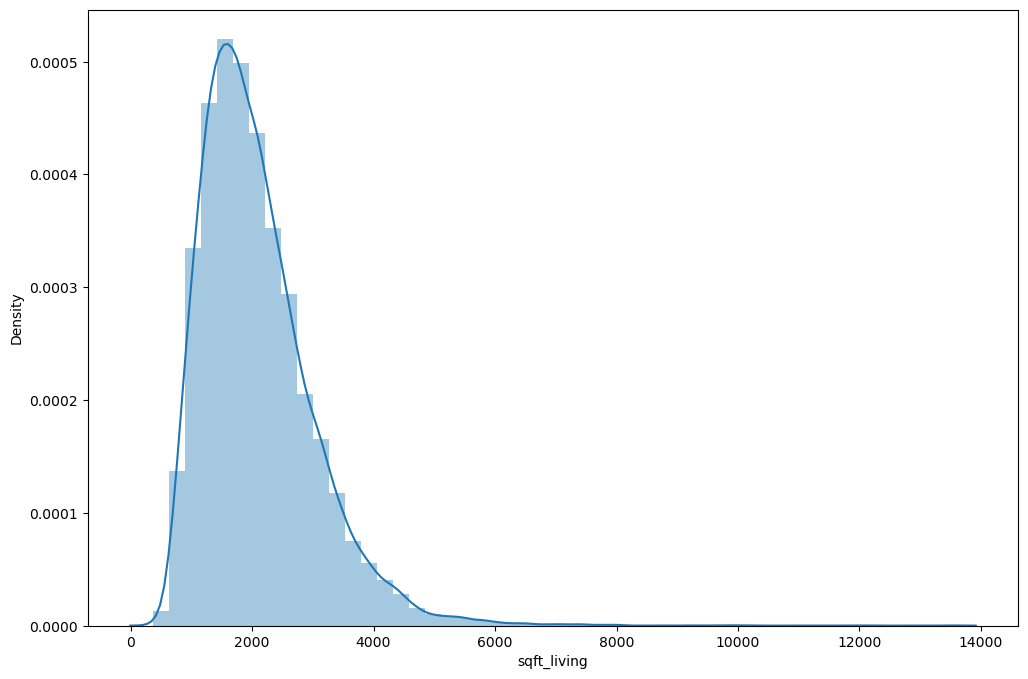

In [244]:
plt.figure(figsize = (12,8))
sns.distplot(data['sqft_living'])

What we observe is quite similar from the price distribution the bulk of thr properties are around the 2000sqft mark and there are some outliers.

### 3.5.2 Bedrooms and Bathroom Distribution

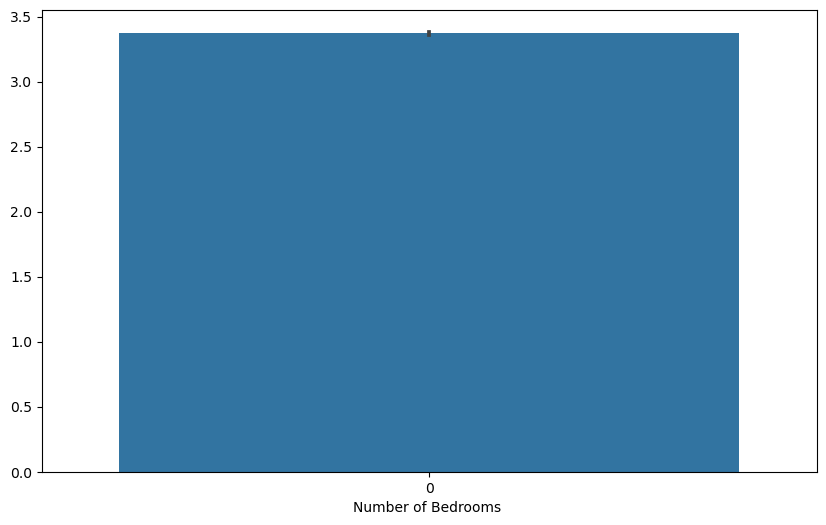

In [245]:
# here I use the countplot to look at the distribution of bedrooms
plt.figure(figsize = (10,6))
sns.barplot(data["bedrooms"])
plt.xlabel("Number of Bedrooms ")

plt.show()

<Axes: xlabel='bedrooms', ylabel='price'>

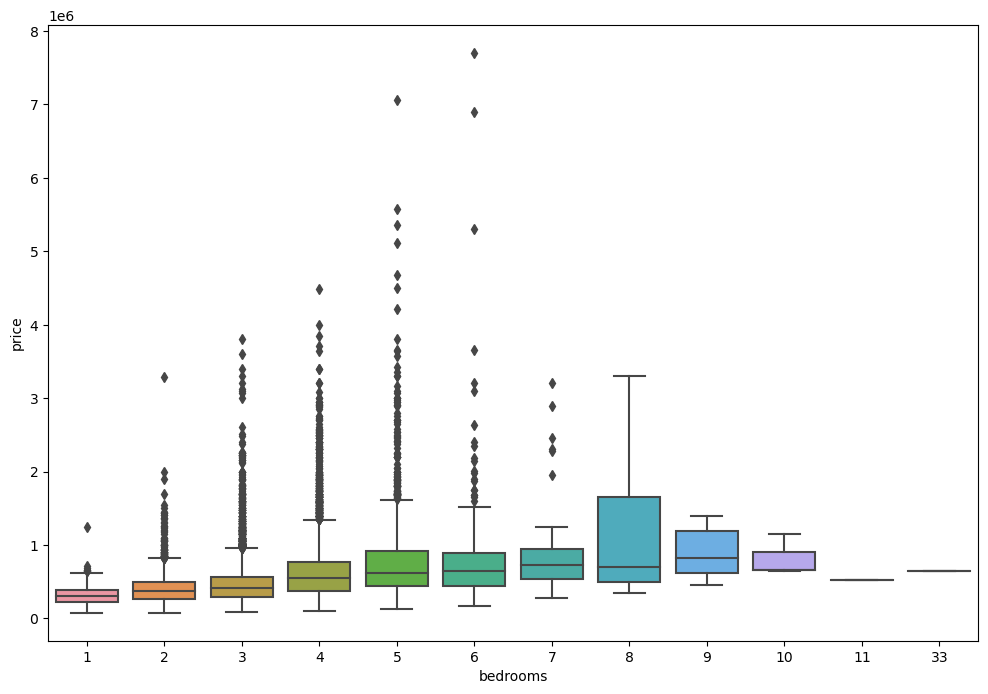

In [246]:
# Here plot aboxplot to see a link btwn the price and thenumber of bedrooms
plt.figure(figsize = (12,8))
sns.boxplot(x='bedrooms', y= 'price', data=data)

What I observe here the highest price of a property has a total of 6 bedrooms and there also some extreme values which tend to be outliers.

There is a positive correlation between the number of bedrooms and price, in each instance we get the meadian and the percentiles and the outliers 

<Axes: xlabel='bathrooms', ylabel='price'>

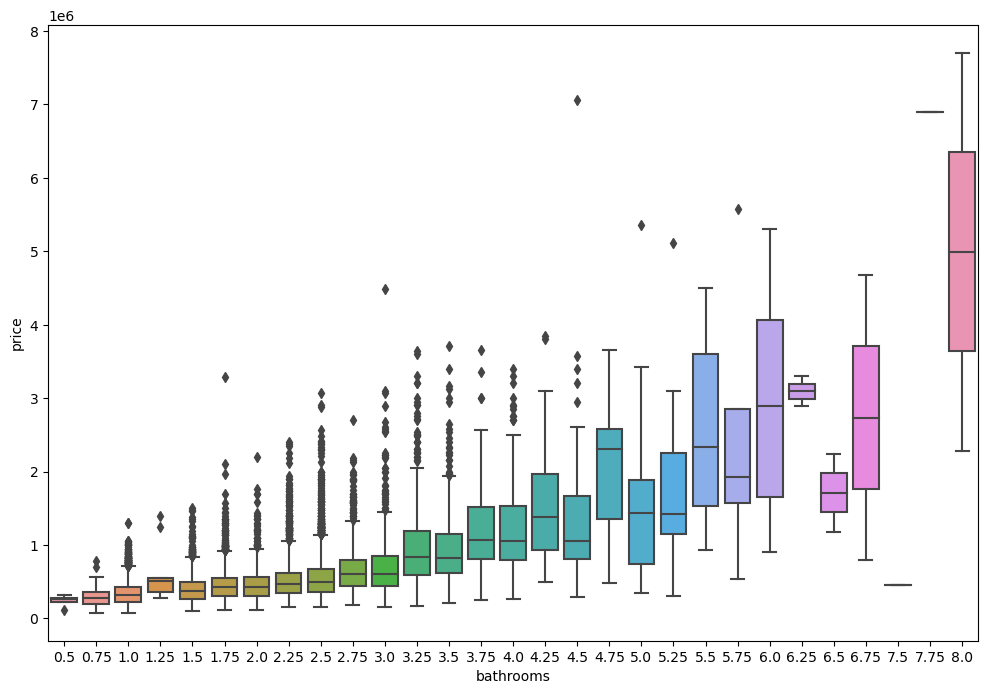

In [247]:
# Bathroom 
plt.figure(figsize = (12,8))
sns.boxplot(x='bathrooms', y='price', data=data)

Here we can check if bathroom is correlated with higher pricing.
? Seems as if it is as you have a higher number of bathrooms makes the properties price skyrocket.

A higher number of bathrooms and bedrooms leads to a higher amount of living space.

### 3.5.3  Grade Distribution 

In [271]:
# Convert the "grade" column to numerical data
data['grade'] = data['grade'].str.split().str[0].astype(int)

# Display the updated dataframe
print(data['grade'].head(15))


0      7
1      7
2      6
3      7
4      8
5     11
6      7
7      7
8      7
9      7
10     8
11     7
12     7
13     7
14     7
Name: grade, dtype: int32


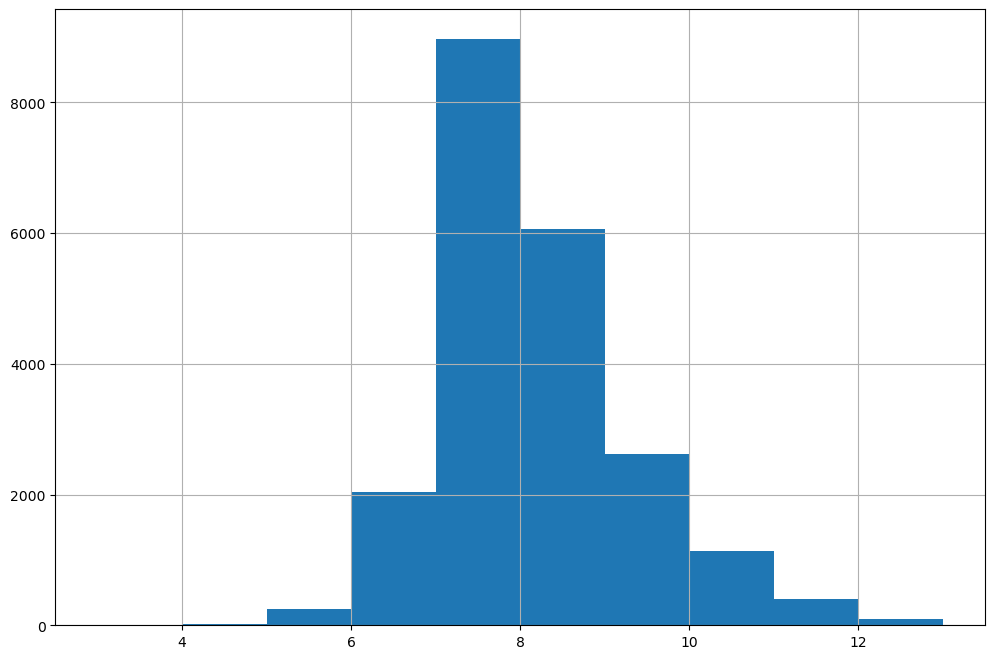

In [249]:
import pylab as P
plt.figure(figsize = (12,8))
data['grade'].hist()

P.show()

THe is a grading system from 1 - 13. THe higher the grade the higher the property price . THe average grade is about 7.6 

(-0.5, 10.5, 0.0, 8000000.0)

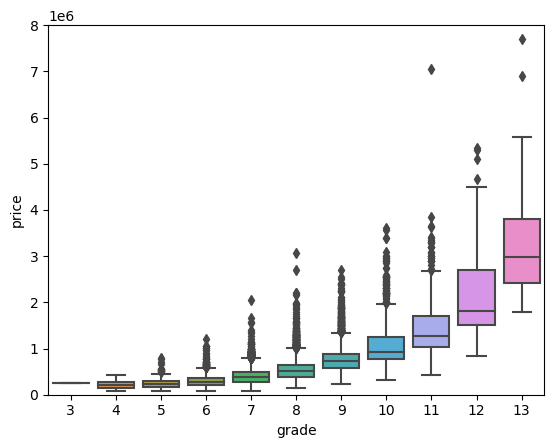

In [250]:
fig = sns.boxplot(x='grade', y='price', data=data)
fig.axis(ymin=0, ymax=8000000)

For grade and the price of property the higher the grade the higher the property price.  

### 3.5.4 Year Built 

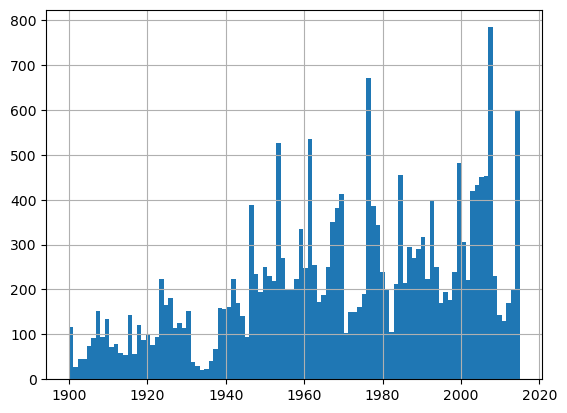

In [251]:
data['yr_built'].hist(bins = 100)
P.show()

This helps when we want to look at the housing stock and the properties that are sold between 2014 and 2015. 

<Axes: xlabel='floors', ylabel='count'>

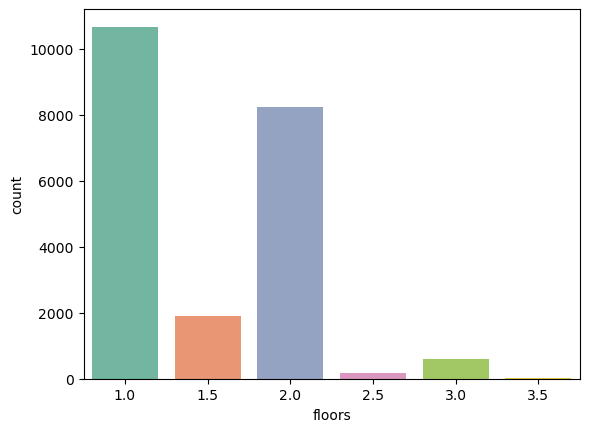

In [252]:
sns.countplot(x='floors', data=data, palette='Set2')

## 3.6 Scatter plot of Price vs Living Space 

<Axes: xlabel='sqft_living', ylabel='price'>

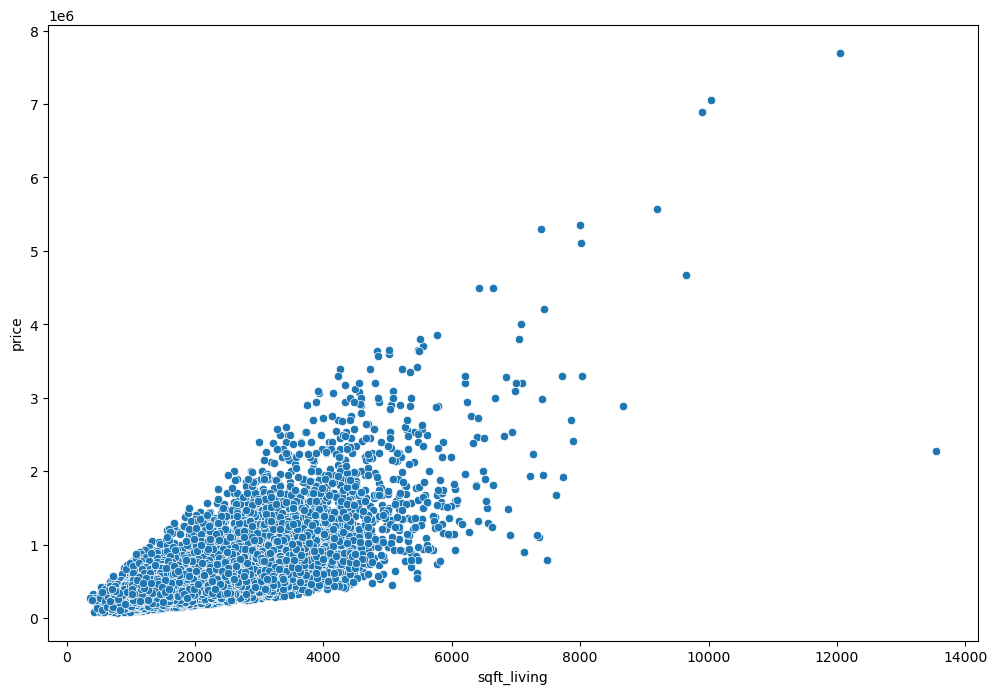

In [253]:
plt.figure(figsize = (12,8))
sns.scatterplot(x='sqft_living', y='price', data=data)

In this section we have a scatter plot comparing price and living space.It is very clear as we increase the living space area the price of the property goes up meaning there is a positive relationship.

But due to outliers the line of best fit mught be affeted.


<Axes: xlabel='sqft_lot', ylabel='price'>

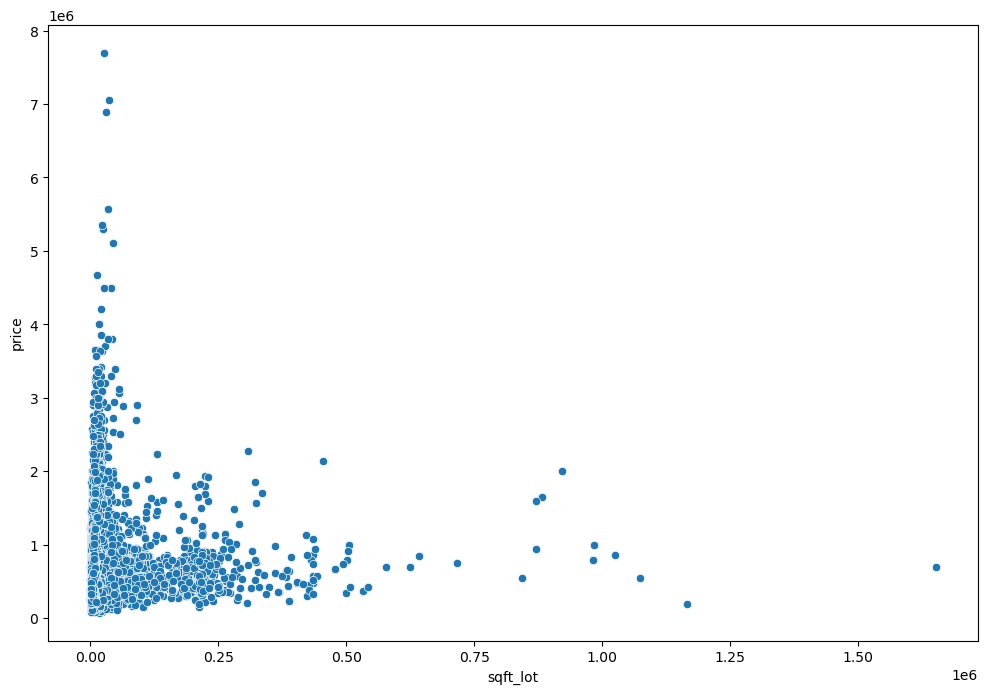

In [254]:
plt.figure(figsize = (12,8))
sns.scatterplot(x='sqft_lot', y='price', data=data)

The lot is the area around the property.
Obviously its apositive relationship for the line of best they maybe 1 or more.

## 3.7 Waterfront Properties 

<Axes: xlabel='waterfront', ylabel='price'>

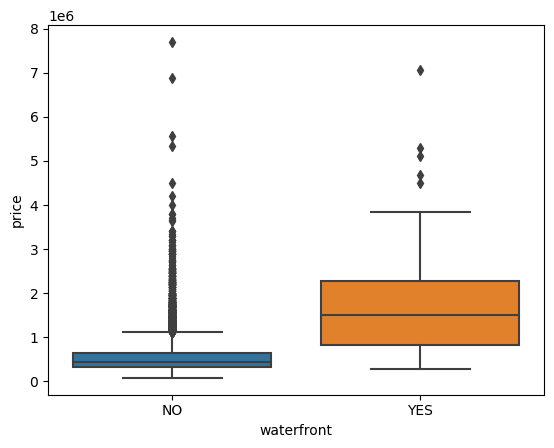

In [255]:
sns.boxplot(x='waterfront', y='price', data=data)

The waterfront simply means there is a property near a lake or ocean.

Compared to the properties that don't have waterfront a property close to a waterfront are expensive.

### 3.8  Longitude and Latitude 

<Axes: xlabel='long', ylabel='lat'>

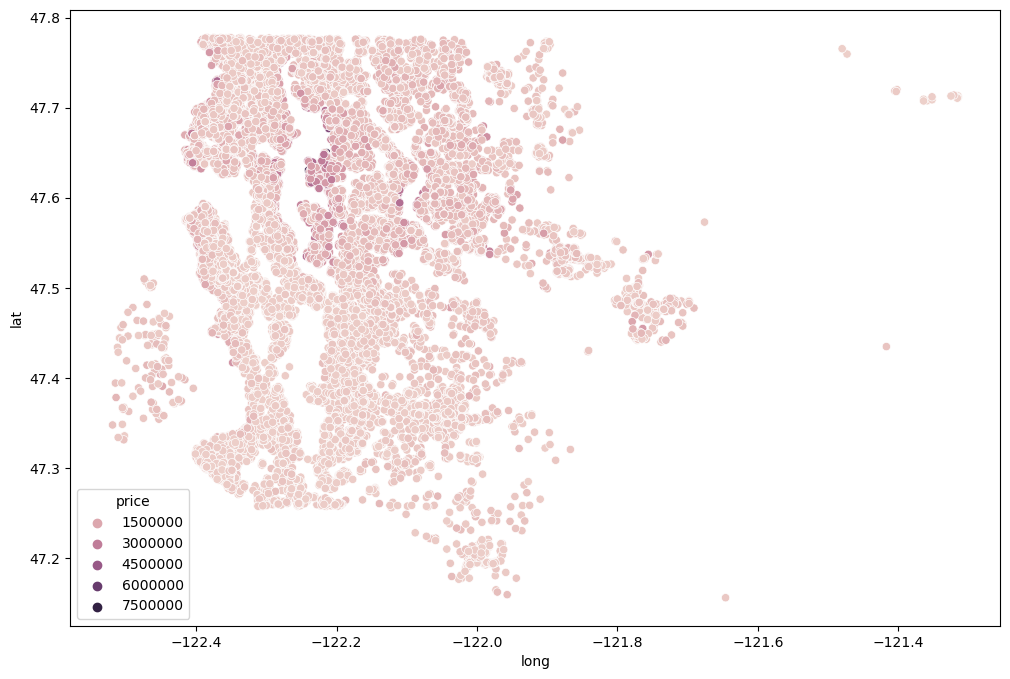

In [256]:
plt.figure(figsize = (12,8))
sns.scatterplot(x='long', y='lat', data=data, hue='price')

I can see that the area close to the waterfront are the highest prices they have a dark tone.



## 3.9 The Correlation Matrix

What this simply means we;re trying to find what is the interrelationships between the variables.

In [257]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [268]:
dCol = ['date', 'waterfront', 'view', 'condition', 'sqft_basement']
data.drop(dCol, axis=1, inplace=True)
data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,7 Average,1180,1955,0.0,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,7 Average,2170,1951,1991.0,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,6 Low Average,770,1933,NaN,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,7 Average,1050,1965,0.0,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,8 Good,1680,1987,0.0,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,8 Good,1530,2009,0.0,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,8 Good,2310,2014,0.0,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,7 Average,1020,2009,0.0,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,8 Good,1600,2004,0.0,47.5345,-122.069,1410,1287


In [272]:
# Finding out the correlation between the features
corr = data.corr()
corr.shape

(14, 14)

<Axes: >

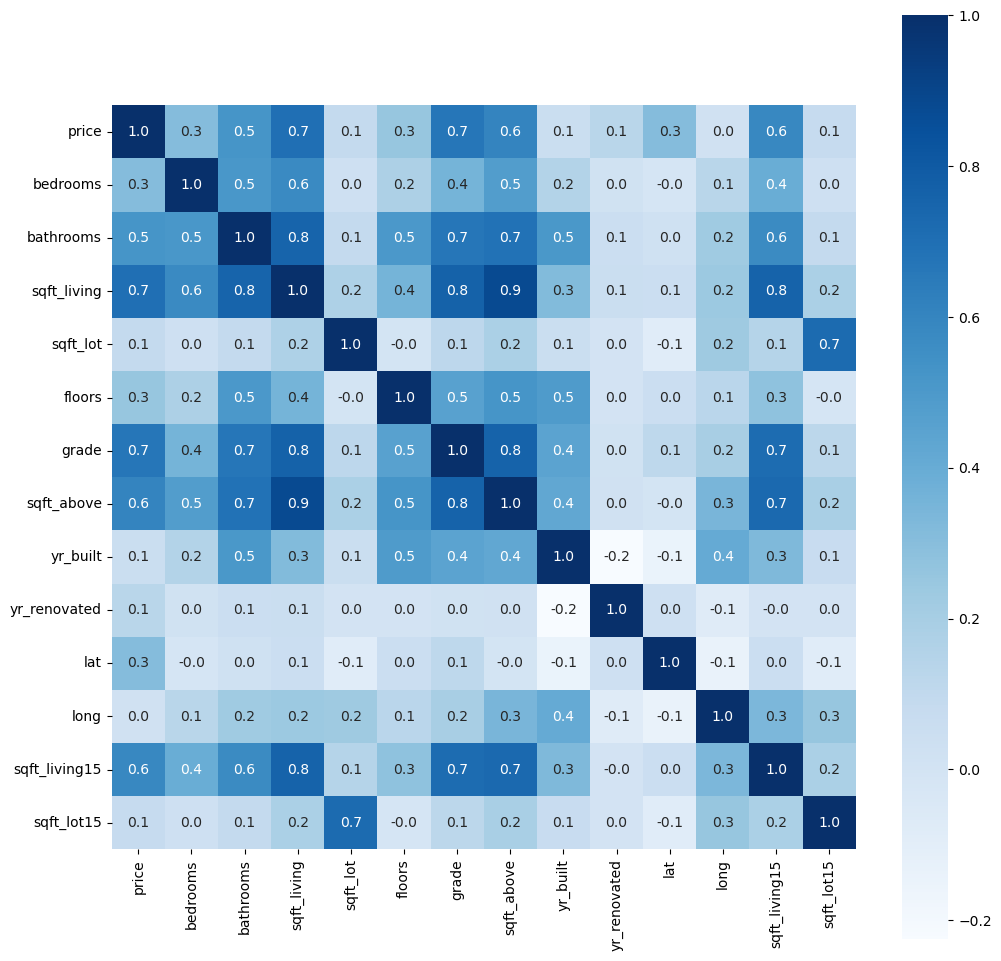

In [273]:
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size': 10}, cmap='Blues')


The dark blues denoted a positive correlation where the maximu correlation is 1 and the minimum correlation would be around -6.

Reading this i would say price is correlated to itself.


In [266]:
## Drop some fields 
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [267]:
ACol = ['id', 'zipcode']
data.drop(ACol, axis=1, inplace=True)
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,2009,0.0,47.6993,-122.346,1530,1509
21593,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,2014,0.0,47.5107,-122.362,1830,7200
21594,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,2009,0.0,47.5944,-122.299,1020,2007
21595,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,Average,8 Good,1600,0.0,2004,0.0,47.5345,-122.069,1410,1287


In [292]:
Col = ['yr_renovated']
data.drop(Col, axis=1, inplace=True)
data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,7,1180,1955,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,7,2170,1951,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,6,770,1933,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,7,1050,1965,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,8,1680,1987,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,8,1530,2009,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,8,2310,2014,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,7,1020,2009,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,8,1600,2004,47.5345,-122.069,1410,1287


## 4.0 Modeling 

## 4.1 Full Sample target variable and independent variables


In [293]:
# Here i put the data into 2 variable 
X = data.drop(['price'], axis = 1)  # independent variable 
y = data['price']  #target variable 

Here we are filtering the columns that the expanatory variables include except price and the target variable we want to model is the price.

## 4.2 Splitting the Data to Train and test data

In [294]:
# import the necessary library for splitting data 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 4)

Here we split the dataset into train and test basically we train the algorithm to estimate the OLS model the ordinary least squares using the train data and then we test that data and parameterize our model and using this model we predict what the y-value should be based on testing data.

The splitting of data is done in a very particular way say 0.3 is put for testing the data and the other 70% used for training. We estimate our model using the training data with our y - price  and x - everything else.

This is done with 70% of the data, we take the model parameters and then we load in the tesing data  we predict what the y value shloud be based on x test data. The explanatory variables are put into the model and we predict out what the price should be based on the testing data. We use the accuracy from predicting using the testing data which is in sample but we use the out sampleto see how robust my model is.

##  4.3 Linear Regression 

In [295]:
# import necessary libraries
from sklearn import metrics 
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression 

In [296]:
# Create a linear regressor 
lm = LinearRegression()
lm

LinearRegression()

In [297]:
# Trainthe model using the training sets 
lm.fit(X_train, y_train)

LinearRegression()

The most common type of analysis I would typically use is OLS - Ordinary Least Squares regression type estimate.
The key here is that Am using the training data. My linear regression model am regressing my x's onto the y's.

## 4.3.1 Model Prediction on train data 

In [299]:
# Model prediction ontrain data 
y_pred = lm.predict(X_train)

For this part I predict the y - I want to look at the model prediction using the training data.

## 4.3.2 Model Evaluation

In [300]:
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.6530241275229682
Adjusted R^2: 0.6527484581327587
MAE: 132506.20582581934
MSE: 46502593973.54427
RMSE: 215644.6010767352


Here I wamt to find what kind of accuracy and r-squared and adj r-squared which take control of the degrees of freedom.

The highest r-squared is 1 or 100 am getting 65 which is not bad 

## 4.3.3 Visualizing the differences between actual prices and predicted values 

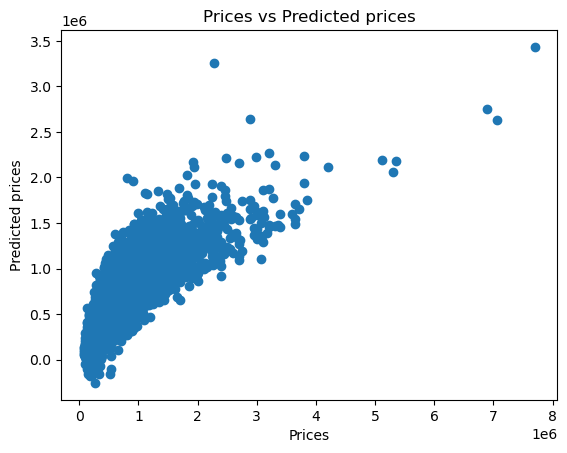

In [301]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

I visualize the predicted price vs actal price, this is for the 70% of training data.

If it was 100% perfect we would get a straight line but we're getting a non-linear effect.

### 4.3.4  Inspecting residuals

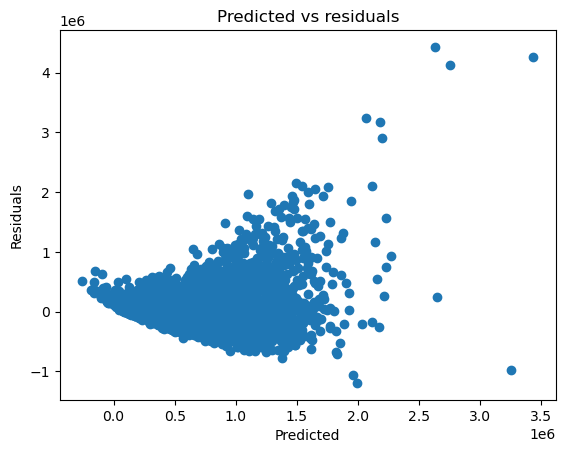

In [302]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

We are going to look at the errors predicted price vs. reiduals. There is alittle bit of an arc the widening out and the maximum value is quite off.

So the residual is the level of error in the estimation the difference the predicted  and the actual.

## 4.3.5  Checking Normality of errors 

C:\Users\PC\AppData\Local\Temp\ipykernel_9240\3326403628.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




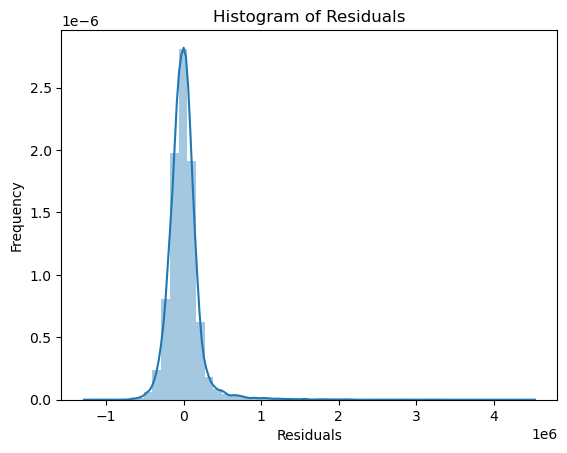

In [303]:
# Checking Normality of errors
sns.distplot(y_train-y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

We can check if we're getting some kind of normal distribution in errors, from the above plot seems like we're close to normality wh ere mean = 0, and the skew to the left.  

## 4.3.6 Model Evaluation for OLS

In [304]:
# Predicting Test data with the model
y_test_pred = lm.predict(X_test)

In [305]:
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.6596348668821379
Adjusted R^2: 0.6590032940357773
MAE: 135465.13318977537
MSE: 46649997608.3688
RMSE: 215986.10512801234


For the model evaluation I use the test data which is 30% and stick that into My model and see what level I will be getting.
This helps to determine how good my model is.

We're still getting the same R^2 and adj R^2 as the training data 

# 4.4 Random Forest: Import Random Forest Regressor

This is another type of modelling called Random Forest.
It's simmlar to a decision tree except it does multi-sampling, instead of creating a single classification or linear regression it does many trees making it form a forest.

Process is similar to the OLS 

In [306]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg = RandomForestRegressor()

# Train the model using the training sets 
reg.fit(X_train, y_train)

RandomForestRegressor()

It is computationally intensive type estimation compared to the estimation in OLS.

## 4.4.1 Model Evaluation

Predict the data 

In [307]:
# Model prediction on train data
y_pred = reg.predict(X_train)

In [308]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9775564569017258
Adjusted R^2: 0.9775386256969337
MAE: 27935.761636260973
MSE: 3007941055.3132195
RMSE: 54844.699427685984


In [ ]:
We're getting r^2 of 97 which is good.

##  4.4.2 Visualizing the differences between actual prices and predicted values

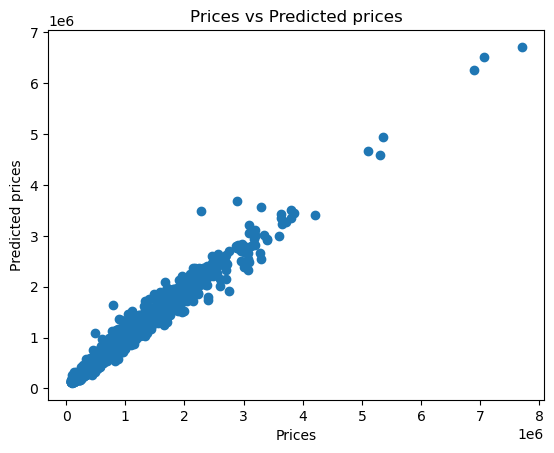

In [309]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

In [ ]:
It looks more of a stright line tha OLS.

## 4.4.3 Checking residuals

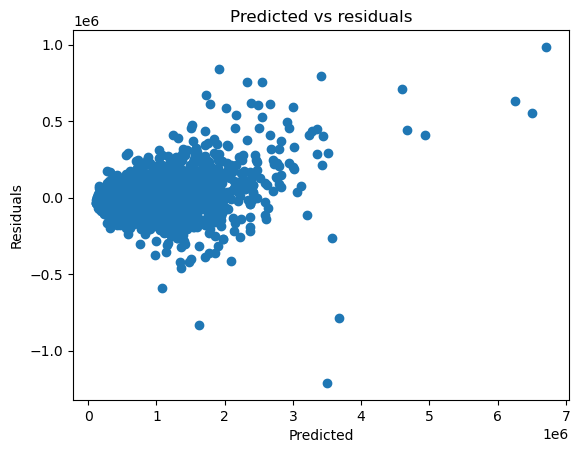

In [310]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

We have errors ranging from different prices but random forests seems to perfom quite well. 

## 4.4.4  Predicting Test data with the model

In [312]:
# Predicting Test data with the model
y_test_pred = reg.predict(X_test)

In [ ]:
In predicting the remaining part of the test data 

## 4.4.5  Model Evaluation

In [313]:
# Model Evaluation
acc_rf = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.8567782574328247
Adjusted R^2: 0.8565124988259272
MAE: 74340.09822350455
MSE: 19629783717.92135
RMSE: 140106.33004229804


We get a measure of accuracy using R^2 and adj R^2.
We've gone from 97% to 85% that quite a drop in the value of R^2
which tends to say it is not robust but tends to perfoms well 85% r^2 is acceptable.

#  4.5 XGBoost: Import XGBoost Regressor

In [328]:
# Import XGBoost Regressor
from xgboost import XGBRegressor

#Create a XGBoost Regressor
reg = XGBRegressor()

# Train the model using the training sets 
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

This is also aonther tree estimator and its been introduced recently and people been using it in competitions.

Tends to be computationally fast in estimation speed.

Followed the same format as the rest.

##  4.5.1 Model Evaluation

In [322]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.9775564569017258
Adjusted R^2: 0.9775386256969337
MAE: 27935.761636260973
MSE: 3007941055.3132195
RMSE: 54844.699427685984


### 4.5.2 Visualizing the differences between actual prices and predicted values

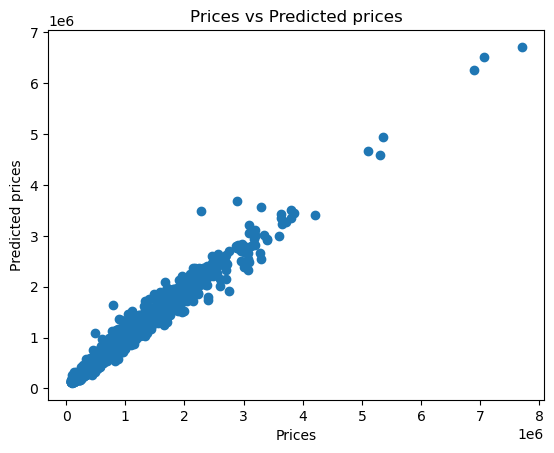

In [323]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

Its showing a different behavior not quite a  straight line.


## 4.5.3 Predicting Test data with the model

In [324]:
#Predicting Test data with the model
y_test_pred = reg.predict(X_test)

In [331]:
# Model Evaluation
acc_xgb = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_xgb)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.8460800203071482
Adjusted R^2: 0.8457944103247276
MAE: 77094.87084056714
MSE: 21096070031.548386
RMSE: 145244.86232410558


# 5.0 Regression Results 

## 5.1  Models Compared

In [326]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R-squared Score': [acc_linreg*100, acc_rf*100, acc_xgb*100]})
models.sort_values(by='R-squared Score', ascending=False)

,Model,R-squared Score
1,Random Forest,85.677826
2,XGBoost,84.608002
0,Linear Regression,65.963487


## 6.0 Conclusion 

Linear Regression:
* The R-squared value for the training data is 0.653, indicating that the linear regression model explains about 65.3% of the variance in the target variable.
* The R-squared value for the testing data is 0.660, suggesting that the model generalizes reasonably well to unseen data.
* The MAE (Mean Absolute Error) is 132,506, which represents the average difference between the predicted and actual prices.
* The RMSE (Root Mean Squared Error) is 215,644, indicating the average magnitude of the residuals.

Random Forest Regression:
* The R-squared value for the training data is 0.978, suggesting that the random forest model explains about 97.8% of the variance in the target variable.
* The R-squared value for the testing data is 0.857, indicating a good level of generalization.
* The MAE is 27,935, which is significantly lower than the MAE of the linear regression model.
* The RMSE is 54,844, indicating smaller residuals compared to linear regression.


XGBoost Regression:
* The R-squared value for the training data is 0.978, similar to the random forest model.
* The R-squared value for the testing data is 0.846, slightly lower than the random forest model but still a good fit.
* The MAE is 77,094, which is higher than the MAE of the random forest model.
* The RMSE is 145,245, indicating larger residuals compared to the random forest model.

Based on the R-squared scores, the random forest regression model performs the best, followed by XGBoost regression and linear regression. However, it's essential to consider other factors such as model complexity, interpretability, and computational efficiency when selecting the best model for your specific use case.

## 7.0 Recommendations 


Random Forest Regression:

* The random forest regression model performed the best among the three models, with a higher R-squared value and lower error metrics.
* Consider using the random forest model for predicting house prices based on the given dataset.
* Since random forest models are robust and can handle a large number of features, you can further explore feature engineering to improve the model's performance. This may involve creating new features, transforming existing features, or including interaction terms.

XGBoost regression:
* The XGBoost regression model also performed well, although slightly lower than the random forest model in terms of R-squared and error metrics.
* Consider XGBoost as an alternative if you prefer a more computationally efficient model compared to random forest or if XGBoost provides better interpretability for your use case.
* Similar to the random forest model, explore feature engineering and hyperparameter tuning to improve the XGBoost model's performance.


The linear regression:
* The linear regression model had the lowest R-squared value and higher error metrics compared to the ensemble models.
However, linear regression can still provide valuable insights into the relationships between independent variables and the target variable.
* Consider using the linear regression model for explanatory purposes, such as understanding the impact of different features on house prices and identifying significant predictors.
* Assess the statistical significance of the coefficients and p-values in the linear regression model to gain insights into the relationships between variables.

General Recommendations:
* Further investigate the dataset to identify potential outliers, missing values, or anomalies that could affect the model's performance. Preprocess the data accordingly by handling outliers, imputing missing values, or normalizing variables.
* Explore additional features or external data sources that could enhance the predictive power of the models. For example, you could consider incorporating demographic data, crime rates, or school district information if available and relevant to house prices.